<a href="https://colab.research.google.com/github/cverluise/PatCit/blob/nightly/notebook/frontpage_wiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.cloud import bigquery
from google.oauth2 import service_account

# Set up

> If you don't have the JSON file that contains your key yet, follow the instructions to [create a service account](https://cloud.google.com/docs/authentication/getting-started#creating_a_service_account)

In [2]:
# Upload your credentials
uploaded = files.upload() 

Saving npl-parsing-3412b4cafd20.json to npl-parsing-3412b4cafd20.json


In [3]:
key_path = "./npl-parsing-3412b4cafd20.json" # change the name to match your credentials file name

In [4]:
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [ ]:
wiki_table = "patcit-public-data.frontpage.wiki"


# Graph

The graph can be seen as a bipartite graph where the 2 disjoint set of nodes are:

1. wiki pages
1. patents

Graphic representation of a bipartite directed graph [here](https://www.researchgate.net/publication/333505764/figure/fig5/AS:764459744247808@1559272814030/A-complete-directed-bipartite-graph-between-the-sets-of-likes-and-dislikes_W640.jpg).

**Warning** This is a simplified representation. IRL, wiki pages can cite patents as well and both patents and wiki pages exhibit (a lot of) "within" citations.



### Nodes

In [ ]:
query = f"""
SELECT
  COUNT(patcit_id) as nb_wiki_nodes
FROM
  `{wiki_table}`
"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
print(f"There are {int(tmp['nb_wiki_nodes'].values)} wiki nodes")

There are 70052 wiki nodes


> Note: we know that there are still duplicates

In [ ]:
query = f"""SELECT
  COUNT(DISTINCT(cited_by.publication_number)) as nb_patent_nodes
FROM
  `{wiki_table}`,
  UNNEST(cited_by) as cited_by
"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
print(f"There are {int(tmp['nb_patent_nodes'].values)} patent nodes")

There are 64224 patent nodes


### Edges

In [ ]:
query = f"""
SELECT
  SUM(is_cited_by_count) as nb_edges
FROM
  `{wiki_table}`
"""  

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
print(f"There are {int(tmp['nb_edges'].values)} edges")

There are 108475 edges


### Degrees

#### In-degree

In [ ]:
query = f"""
SELECT
  is_cited_by_count,
  COUNT(patcit_id) as nb_occ,
FROM
  `{wiki_table}`
GROUP BY
  is_cited_by_count
"""

In [ ]:
tmp = client.query(query).to_dataframe()

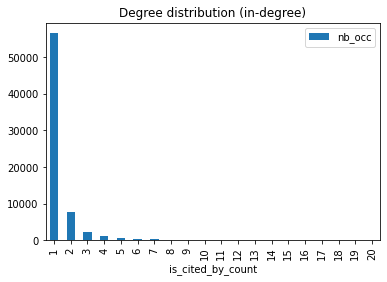

In [ ]:
(tmp
 .set_index("is_cited_by_count")
 .iloc[:20] # truncated
 .plot(kind="bar", title="Degree distribution (in-degree)"));

There is a fat tail

#### Out degree

In [ ]:
query = f"""WITH
  tmp AS (
  SELECT
    COUNT(cited_by.publication_number) AS nb_cit_wiki,
    cited_by.publication_number
  FROM
    `{wiki_table}`,
    UNNEST(cited_by) AS cited_by
  GROUP BY
    cited_by.publication_number )
SELECT
  nb_cit_wiki,
  COUNT(nb_cit_wiki) as nb_occ
FROM
  tmp
GROUP BY
  nb_cit_wiki"""

In [ ]:
tmp = client.query(query).to_dataframe()

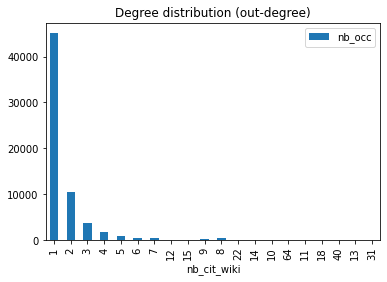

In [ ]:
(tmp
 .set_index("nb_cit_wiki")
 .iloc[:20] # truncated
 .plot(kind="bar", title="Degree distribution (out-degree)"));

### Centrality

In [ ]:
query = f"""SELECT
  item,
  SUM(is_cited_by_count) AS nb_cit
FROM
  {wiki_table},
  UNNEST(item) AS item
GROUP BY
  item"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
# Top n most cited items (rough measure of centrality)
(tmp
 .sort_values("nb_cit", ascending=False)
 .head(10))

,item,nb_cit
124,Cancer,304
1086,Mammal,235
924,Viruses,213
1039,Murinae,204
1171,Plant,194
1214,Fungi,165
1217,List of sequenced bacterial genomes,164
6,Bluetooth,156
492,Grid Offerings,144
1339,Elliptical Polarization,125


# Characteristics of wiki citations

In short, the "average" wiki citation is coming from:

- the applicants 
- of a patent published at the USPTO 
- in the 2010s

> The technological class of the citing patents is biased towards cpc codes which don't appear anymore in the cpc scheme (see https://www.cooperativepatentclassification.org/cpcSchemeAndDefinitions/table)

### By year

In [ ]:
query = """
SELECT
  CAST(cited_by.publication_date/10000 AS INT64) as publication_year,
  COUNT(cited_by.publication_number) as nb_citations
FROM
  `patcit-public-data.frontpage.wiki`,
  UNNEST(cited_by) as cited_by
GROUP BY
  publication_year
"""

In [ ]:
tmp = client.query(query).to_dataframe()

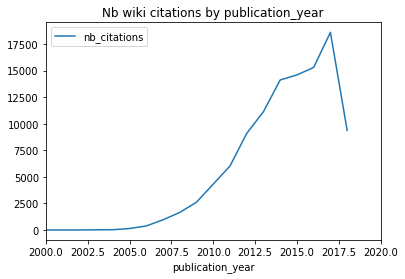

In [ ]:
(tmp
 .sort_values("publication_year")
 .set_index("publication_year")
 .plot(title="Nb wiki citations by publication_year", xlim=(2000, 2020)));

### By country

In [ ]:
query = f"""
SELECT
  SPLIT(cited_by.publication_number, "-")[
OFFSET
  (0)] AS country_code,
  COUNT(cited_by.publication_number) AS nb_cit
FROM
  {wiki_table},
  UNNEST(cited_by) AS cited_by
GROUP BY
  country_code
  """

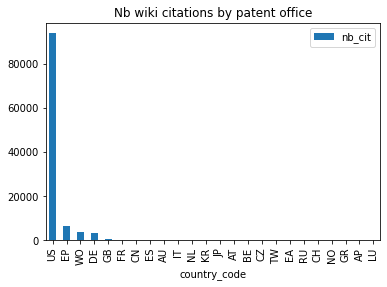

In [ ]:
(tmp
 .sort_values("nb_cit", ascending=False)
 .set_index("country_code")
 .plot(kind="bar", title="Nb wiki citations by patent office"));

### By origin (App, ISR, etc)

In [ ]:
query = f"""SELECT
  cited_by.origin AS origin,
  COUNT(cited_by.publication_number) AS nb_cit
FROM
  {wiki_table},
  UNNEST(cited_by) AS cited_by
GROUP BY
  origin"""

In [ ]:
tmp = client.query(query).to_dataframe()

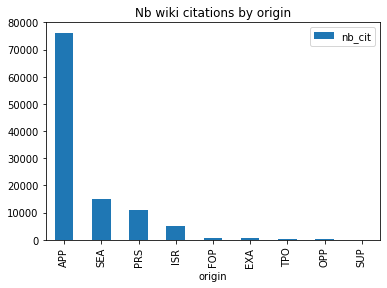

In [ ]:
(tmp.sort_values("nb_cit", ascending=False)
 .set_index("origin")
 .plot(kind="bar", title="Nb wiki citations by origin"));

### By technological class

In [ ]:
query_all = """SELECT
  cpc.code AS cpc_code,
  COUNT(publication_number) AS nb # not distinct, just the nb of lines
FROM
  `patents-public-data.patents.publications`,
  UNNEST(cpc) AS cpc
WHERE
  country_code="US"
  AND publication_date>=20100000
GROUP BY
  cpc_code
ORDER BY
  nb DESC  """

query = """WITH
  cpcs AS (
  WITH
    pubnums AS (
    WITH
      tmp AS (
      SELECT
        cited_by.publication_number AS cited_by_pubnum_
      FROM
        `npl-parsing.patcit.fp_wiki_dev_beta`,
        UNNEST(cited_by) AS cited_by)
    SELECT
      cited_by_pubnum
    FROM
      tmp,
      UNNEST(cited_by_pubnum_) AS cited_by_pubnum )
  SELECT
    pubnums.cited_by_pubnum,
    p.cpc
  FROM
    pubnums
  LEFT JOIN
    `patents-public-data.patents.publications` p
  ON
    pubnums.cited_by_pubnum=p.publication_number)
SELECT
  cpc.code AS cpc_code,
  COUNT(cited_by_pubnum) AS nb # not distinct, just the nb of lines
FROM
  cpcs,
  UNNEST(cpc) AS cpc
GROUP BY
  cpc_code
ORDER BY
  nb DESC"""

In [ ]:
cpc_df = client.query(query_all).to_dataframe()
cpc_tmp = client.query(query).to_dataframe()

In [ ]:
def get_odds(lvl:str):
  """Compute the odds ratio by cpc code at level <lvl>"""
  cpc_level = {"section":1, "class":3, "subclass":4}
  assert lvl in list(cpc_level.keys())
  
  cpc_df[f"cpc_{lvl}"] = (cpc_df["cpc_code"]
                            .apply(lambda x: x[:cpc_level[lvl]]))
  cpc_tmp[f"cpc_{lvl}"] = (cpc_tmp["cpc_code"]
                           .apply(lambda x: x[:cpc_level[lvl]]))
  cpc_df_sub = (cpc_df.groupby(f"cpc_{lvl}").sum()/cpc_df["nb"].sum()).rename(columns={"nb":"share"})
  cpc_tmp_sub = (cpc_tmp.groupby(f"cpc_{lvl}").sum()/cpc_tmp["nb"].sum()).rename(columns={"nb":"share"})
  out = cpc_df_sub.merge(cpc_tmp_sub, how="left", 
                   right_index=True, left_index=True, 
                   suffixes=("", "_wiki"))
  out["odds"] = out["share_wiki"]/out["share"]
  out = out.sort_values(by="odds", ascending=False)
  return out

#### Class

In [ ]:
get_odds("class").head(10)

,share,share_wiki,odds
cpc_class,,,
Y01,1.742023e-07,8.637923e-06,49.585581
H40,5.123597e-08,1.233989e-06,24.084425
A64,4.098878e-08,6.169945e-07,15.052766
C70,6.148317e-08,6.169945e-07,10.035177
G60,3.996406e-07,2.467978e-06,6.175494
A63,1.112876e-02,3.888423e-02,3.494030
A16,1.946967e-07,6.169945e-07,3.169003
G06,9.820183e-02,2.325242e-01,2.367820
Y04,6.238082e-04,1.217947e-03,1.952438


> There seems to be something weird happening there. The cpc classes with the highest odds ratios do not exist (anymore) in official tables (e.g. https://www.cooperativepatentclassification.org/cpcSchemeAndDefinitions/table)

TODO: 

- Unravel the cpc code mystery
- Look at how wikipedia categories and cpc codes relate together
- Look for characteristics of cited wiki pages (ent, concept, etc) that could help us better understand the citation intent

Current guess is that applicants use wiki definitions to standardize emerging concepts which are still not clearly defined by official organizations/ the scientific world.